## Importing Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.model_selection import GridSearchCV, StratifiedKFold,train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from typing import Tuple, List

from preprocessing import add_label

In [3]:
os.getcwd()


'c:\\Users\\Tim\\Development\\INFOMPR\\Project'

## Loading Data

In [4]:
dir = 'data/RAW/VPN-PCAPS-01/cleaned'
# add_label(base_dir='data/RAW/VPN-PCAPS-01',out_dir=dir,out_name='complete')
df = pd.read_csv(f"data/compleet.csv")
df.drop('Label', axis=1, inplace=True)
labels = df.iloc[:,-1:]
# feature_cols = set(df.columns) - set(labels.columns)
cols = pd.read_csv('feature_dtypes.txt', sep=';')
cols = cols.iloc[:,0].to_list()
features = df.loc[:,cols]

## Sanity Checking

In [5]:
features

,Fwd Seg Size Min,Bwd Byts/b Avg,Subflow Fwd Byts,SYN Flag Cnt,Fwd Pkt Len Std,FIN Flag Cnt,Bwd URG Flags,Fwd Seg Size Avg,TotLen Bwd Pkts,Src Port,...,Active Mean,Active Max,Fwd Pkt Len Max,Bwd Pkts/b Avg,Subflow Fwd Pkts,Flow IAT Max,Bwd Pkt Len Std,Active Min,Init Fwd Win Byts,Idle Std
0,0,0,72,0,0.000000,0,0,18.000000,148.0,15685,...,0.0,0.0,18.0,0,4,226931.0,3.265986,0.0,-1,0.000000e+00
1,0,0,0,0,0.000000,0,0,0.000000,0.0,443,...,0.0,0.0,0.0,0,0,26.0,0.000000,0.0,-1,0.000000e+00
2,0,0,0,0,0.000000,0,0,0.000000,10.0,38688,...,0.0,0.0,0.0,0,1,275124.0,0.000000,0.0,-1,0.000000e+00
3,0,0,0,0,0.000000,0,0,0.000000,445.0,54299,...,0.0,0.0,0.0,0,0,950603.0,263.750829,0.0,-1,0.000000e+00
4,0,0,134,0,0.000000,0,0,134.000000,176.0,15685,...,206115.0,206115.0,134.0,0,1,21906100.0,65.240580,206115.0,-1,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,0,0,554,0,159.926025,0,0,138.500000,1449.0,443,...,274042.5,275138.0,277.0,0,4,54589202.0,282.028811,272947.0,-1,1.080621e+07
6230,0,0,0,0,0.000000,0,0,0.000000,37.0,443,...,0.0,0.0,0.0,0,1,21.0,26.162951,0.0,-1,0.000000e+00
6231,0,0,1877,1,122.133222,0,0,14.219697,322533.0,56646,...,0.0,0.0,1308.0,0,132,30443979.0,216.779153,0.0,-1,0.000000e+00
6232,0,0,0,0,0.000000,0,0,0.000000,0.0,56646,...,0.0,0.0,0.0,0,1,334638.0,0.000000,0.0,-1,0.000000e+00


## Exploring

In [6]:
data_described = df.describe()
data_described = data_described[data_described.columns[1:]]
data_described0 = data_described.T[data_described.T['std'] == 0]
data_described_not0 = data_described.T[data_described.T['std'] != 0].T
data_described

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,6234.00000,6234.000000,6.234000e+03,6234.000000,6234.000000,6.234000e+03,6.234000e+03,6234.000000,6234.000000,6234.000000,...,6234.000000,6234.0,6.234000e+03,6.234000e+03,6.234000e+03,6.234000e+03,6.234000e+03,6.234000e+03,6.234000e+03,6.234000e+03
mean,18141.55486,12.284248,3.007207e+07,210.697466,301.566089,2.461169e+04,2.319829e+05,134.950754,16.668110,49.198463,...,133.701636,0.0,7.948703e+05,4.719646e+05,1.385892e+06,4.571403e+05,9.861679e+06,1.508835e+06,1.123419e+07,8.534937e+06
std,20318.10356,5.527759,4.366950e+07,1387.697442,2338.043632,5.374557e+05,2.854762e+06,302.777940,58.994778,119.593311,...,923.592777,0.0,4.310524e+06,2.973666e+06,6.699619e+06,3.588212e+06,1.841833e+07,5.240262e+06,2.028660e+07,1.749617e+07
min,0.00000,0.000000,5.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,443.00000,6.000000,1.323228e+05,0.000000,2.000000,0.000000e+00,2.200000e+01,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5355.00000,17.000000,4.124250e+05,1.000000,2.000000,0.000000e+00,6.300000e+01,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,40007.75000,17.000000,6.283378e+07,4.000000,4.000000,2.157500e+02,2.750000e+02,50.000000,21.000000,28.000000,...,3.000000,0.0,5.471250e+04,0.000000e+00,5.483125e+04,2.542625e+04,1.263208e+07,0.000000e+00,1.801388e+07,7.278777e+06
max,65514.00000,17.000000,1.200000e+08,41587.000000,80734.000000,3.064384e+07,1.052856e+08,1378.000000,864.000000,1296.603188,...,23959.000000,0.0,1.105534e+08,5.655857e+07,1.105534e+08,1.105534e+08,1.194609e+08,7.161495e+07,1.194609e+08,1.194609e+08


## Folding

In [7]:
folds1 = StratifiedKFold(10, shuffle=True, random_state = 32)
folds2 = StratifiedKFold(5, shuffle=True, random_state = 32)

## Hyperparameter tuning

In [30]:
def run_predictions(model, model_param_grid, folds, X_train, X_test, y_train, y_test, conf_mat_png_name = 'confusion_matrix'):
        
       
    clf = GridSearchCV(model(random_state=32), model_param_grid, cv = folds, scoring='accuracy',n_jobs=-1, error_score='raise')
    clf.fit(X_train, y_train)
    
    
    # try:
    #     feature_importances = clf.best_estimator_.feature_importances_
    # except:
    #     feature_importances = clf.best_estimator_.coef_[0]
        
    # importances = pd.DataFrame(data={
    # 'Attribute': cv.get_feature_names_out(),
    # 'Importance': feature_importances
    # })
    # importances = importances.sort_values(by='Importance', ascending=False)
    # print(importances)
    
    # preds = clf.predict(X_test)
    clf_results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').set_index('rank_test_score')
    top_acc_score = clf_results[['mean_test_score']].values[0][0]
    top_acc_score = round(top_acc_score*100)
    
    mtrx = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.savefig(f"results/{str(conf_mat_png_name)}_{top_acc_score}%.png", dpi=512)
    

    return mtrx , clf
#     return {"preds": preds,"clf": clf}

### Using All Features

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)
print(f"made train/test split: {X_train.shape[0]}/{X_test.shape[0]}")

made train/test split: 4987/1247


#### Multi-layer Perceptron Classifier

c:\Users\Tim\Development\INFOMPR\Project\.env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


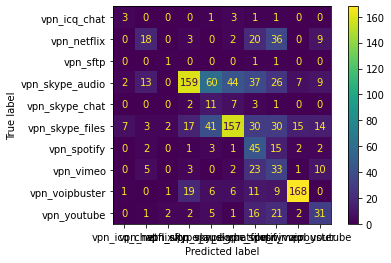

In [31]:
mlp_mtrx, mlp_clf = run_predictions(
    model=MLPClassifier,
    model_param_grid={
        # 'max_iter' : [500],
        # 'batch_size' :[100],
        # 'warm_start' : [True],
        # 'hidden_layer_sizes': [150]
    },
    folds=folds2,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    conf_mat_png_name= 'MultiLayerPerceptronClassifier'
)

In [11]:
mlp_results = pd.DataFrame(mlp_clf.cv_results_).sort_values(by='rank_test_score').set_index('rank_test_score')
mlp_results.to_csv(r'results/mlp_results.csv')
print((mlp_results[['params','mean_test_score','std_test_score']]))

                params  mean_test_score  std_test_score
rank_test_score                                        
1                   {}          0.51031        0.040589


#### Random Forest

array([200, 250, 300, 350, 400, 450,  25,  50,  75, 100, 125])

c:\Users\Tim\Development\INFOMPR\Project\.env\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


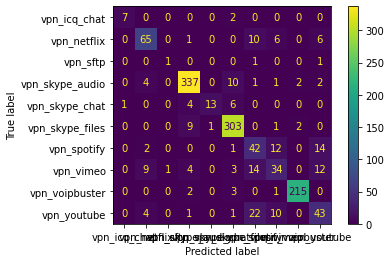

In [35]:
rfc_mtrx, rfc_clf = run_predictions(
    model=RandomForestClassifier,
    model_param_grid={
        'criterion' : ['gini','entropy'],
        'n_estimators' : np.append(np.arange(200,500,50),np.arange(25,150,25)),
        'warm_start' : [True],
        'max_features': ['auto','sqrt','log2'],
        'max_depth': np.arange(5,50,5)
    },
    folds=folds2,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    conf_mat_png_name= 'RandomForestClassifier'
)

In [36]:
rfc_results = pd.DataFrame(rfc_clf.cv_results_).sort_values(by='rank_test_score').set_index('rank_test_score')
rfc_results.to_csv(r'results/rfc_results.csv')
print((rfc_results[['params','mean_test_score','std_test_score']]))

                                                            params  \
rank_test_score                                                      
1                {'criterion': 'gini', 'max_depth': 15, 'max_fe...   
1                {'criterion': 'gini', 'max_depth': 15, 'max_fe...   
3                {'criterion': 'gini', 'max_depth': 15, 'max_fe...   
3                {'criterion': 'gini', 'max_depth': 15, 'max_fe...   
5                {'criterion': 'gini', 'max_depth': 15, 'max_fe...   
...                                                            ...   
590              {'criterion': 'gini', 'max_depth': 5, 'max_fea...   
591              {'criterion': 'gini', 'max_depth': 5, 'max_fea...   
592              {'criterion': 'gini', 'max_depth': 5, 'max_fea...   
593              {'criterion': 'gini', 'max_depth': 5, 'max_fea...   
594              {'criterion': 'gini', 'max_depth': 5, 'max_fea...   

                 mean_test_score  std_test_score  
rank_test_score                       